# Buils convolution neural networks architectures 




## Context


*What is CNN* : **Convolutional neural network (CNN) is a regularized type of feed-forward neural network that learns feature engineering by itself via filters (or kernel) optimization**

*We manipulate a modeste size of data here : only 808* 
- 202 pictures of cat
- 202 pictures of dog
- 202 pictures of human 
- 202 pictures of horse
> We can find the data set in the folder "data_animals" of this project


In [10]:
# Libraries  
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset, DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from helpers import plot

We build a `complete_dataset` containing all the images, to which we apply the following transformations:
- 64x64 image sizes (which may be modified at the end of the tutorial to improve performance) ;
- average at 0.5 ;
- standard deviation at 0.5.

In [2]:
# Path to the directory containing the images
data_dir = "./data_animals"

# Transfomation to apply to the images
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),   # Resize to 64x64
    transforms.ToTensor(),         # Convert to tensor  
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Create a dataset from the images in the directory
complete_dataset = datasets.ImageFolder(root=data_dir, transform=data_transform)

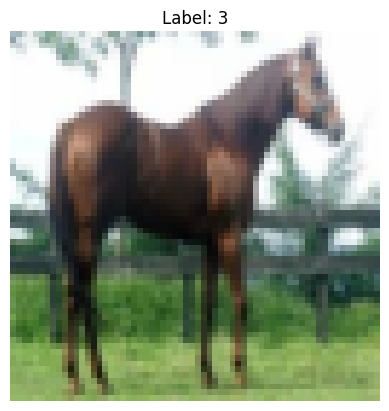

In [9]:
# Define one function to reverse the normalization 
def denormalize(tensor):
    # Clone the tensor to not do the changes in place
    tensor = tensor.clone().detach()
    # Reverse the normalization
    for t, m, s in zip(tensor, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
        t.mul_(s).add_(m)
    return tensor

# We select a random image in the dataset
index = np.random.randint(len(complete_dataset))
sample, label = complete_dataset[index]

# Reverse the normalization to display correctly the image
sample = denormalize(sample)

# Convert the image to numpy
image = sample.numpy().transpose((1, 2, 0))

# Print it
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

Using the `Subset` function in [`torch.utils.data`](https://pytorch.org/docs/stable/data.html#module-torch.utils.data), we will split the `complete_dataset` into two datasets: one for training and one for validation.
 
The images will be distributed between the two datasets in an 80/20 ratio (learning/validation).

We will use these two datasets to feed two DataLoaders `train_loader` and `valid_loader`, for batch sizes of 32.

In [11]:
# Complete len of the dataset
dataset_size = len(complete_dataset)

# List of indices of the dataset
indices = list(range(dataset_size))

# We shuffle the indices randomly
np.random.shuffle(indices)

# The calcul of the split to have one repartition of 80% for the training and 20% for the validation
split = int(np.floor(0.8 * dataset_size)) # 80% train, 20% validation
train_indices, valid_indices = indices[:split], indices[split:]

# Create the Subset for the training and validation
train_dataset = Subset(complete_dataset, train_indices)
valid_dataset = Subset(complete_dataset, valid_indices)

# If we want we can also allow a certain pourcentage of the validation set to be used for the test like this : 
# test_indices = indices[split:int(split + (dataset_size - split) * 0.5)] #80/10/10 split
# test_dataset = Subset(complete_dataset, test_indices)

# Define the batch size for the training and validation
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# If we want to use the test set we can also define the batch size for the test
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# We define our CNN 

We now consider a fairly simple CNN network:
- A CRP layer (Convolution-Relu-MaxPooling) :
  - Convolution on 20 output channels, core size 4x4, stride of 1 
  - Relu activation
  - MaxPooling (3x3 core, 2x2 stride)
- A second CRP layer:
  - Convolution on 50 output channels, 4x4 size core
  - Relu Activation
  - MaxPooling (3x3 core, 2x2 stride)
- Flatten all dimensions (3D tensor to 1D vector)
- Dense layer with 4 outputs

In convolution or max-pooling operations, the filter shifts horizontally and vertically by a certain number of units each time; the stride corresponds to this shift.
 
For example, a stride of 1 moves the filter one pixel at a time
 source : [github pranjalchaubey] :

![CNN_Stride=1](./img/cnn_stride1.gif "https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53")

A stride of 2 moves it by two pixels:

![CNN Stride = 2](./img/cnn_stride2.gif)

A higher stride reduces the amount of computation, but also leads to a loss of information.

The output dimension of a convolution or max-pooling layer (operation) verify : 
$$ O =  \frac{W - K + 2P}{S} + 1 $$

where :
- O is the output size
- W is the input size (width or height)
- K is the core size
- P is the padding
- S is the stride

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First layer CRP (Convolution-Relu-MaxPooling)
        self.crp1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=20, kernel_size=4), # 3 because there is 3 channels of color
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        # Second layer CRP
        self.crp2 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=50, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        # Flatten layer
        self.flatten = nn.Flatten()
        # Last layer (fully connected) with 4 output neurons
        self.fc = nn.Linear(50 * 13 * 13, 4)

    def forward(self, x):
        x = self.crp1(x)
        x = self.crp2(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Create the model
model = SimpleCNN()

# Print the structure of the model
print(model)

# Calculate the output dimension after the Flatten layer
# To do this, we can create an example tensor with the same dimensions as the model input
# (3 channels, 64x64 pixels) and pass it through the network to obtain the output size
input_tensor = torch.randn(1, 3, 64, 64)
output_tensor = model.crp1(input_tensor)
output_tensor = model.crp2(output_tensor)
output_tensor = model.flatten(output_tensor)
flatten_output_dim = output_tensor.size(1)
print("Output dimension after the Flatten layer:", flatten_output_dim)

SimpleCNN(
  (crp1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (crp2): Sequential(
    (0): Conv2d(20, 50, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=8450, out_features=4, bias=True)
)
Output dimension after the Flatten layer: 8450


In [13]:
# Application of the model on an input image from the training Dataset
input_image = train_dataset[0][0].unsqueeze(0)  # Add a batch dimension
output = model(input_image)

print("Output shape:", output.shape)

Output shape: torch.Size([1, 4])


> We fit the model to the training data for the cross-entropy loss `nn.CrossEntropyLoss()` via an SGD (lr = 0.05 without momentum) on a few epochs. For the moment, it's just a question of ensuring that the code works properly.

> Then we will evaluate the error rate on the validation data.
 
 

In [14]:
# Define the loss function
# CrossEntropyLoss is a combination of the Softmax and NLLLoss functions
criterion = nn.CrossEntropyLoss()

# Define the optimizer (SGD with lr = 0.05 without momentum)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0)

# This function takes as input a model and a DataLoader, and returns the error rate of the model on the DataLoader data
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 1 - correct / total

# Training of the model on a few epochs
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        # Forward + Backward + Optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

# Evaluation of the error rate on the validation data
error_rate = evaluate(model, valid_loader)
print("Error rate on validation data:", error_rate)

Epoch 1, Loss: 1.4011719794500441
Epoch 2, Loss: 1.2594568048204695
Epoch 3, Loss: 1.2204220181419736
Epoch 4, Loss: 1.0612071809314547
Epoch 5, Loss: 0.989710617633093
Error rate on validation data: 0.3765432098765432


# SGD and his variation
 
In this section, we want to compare the performance of the SGD and Adam optimisers.
> We define a `Learning_curves` function which takes as its arguments    
> - a model,     
> - an optimizer,     
> - a loss function,
> - and a maximum number of epochs.
>   
> and which returns along the gradient descent the loss and the rate of good rankings for the training sample and for the test sample (i.e. 4 curves).

In [15]:
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SimpleCNN(
  (crp1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (crp2): Sequential(
    (0): Conv2d(20, 50, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=8450, out_features=4, bias=True)
)

In [16]:
# define the learning curve function that will be used to plot the learning curves
def Learning_curves(model, optimizer, criterion, num_epochs, train_loader, valid_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        valid_loss, valid_accuracy = evaluate_model(model, valid_loader, device)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

    return train_losses, train_accuracies, valid_losses, valid_accuracies

def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    average_loss = total_loss / len(dataloader)
    average_accuracy = correct / total
    return average_loss, average_accuracy


> On the graph below, we compare the learning curves for the loss on the training data and the validation data for the following optimisation strategies:
> - SGD lr=0.5
> - SGD lr=0.1
> - SGD lr=0.01
> - SGD lr=0.1 and momentum = 0.5
> - Adam

 
 

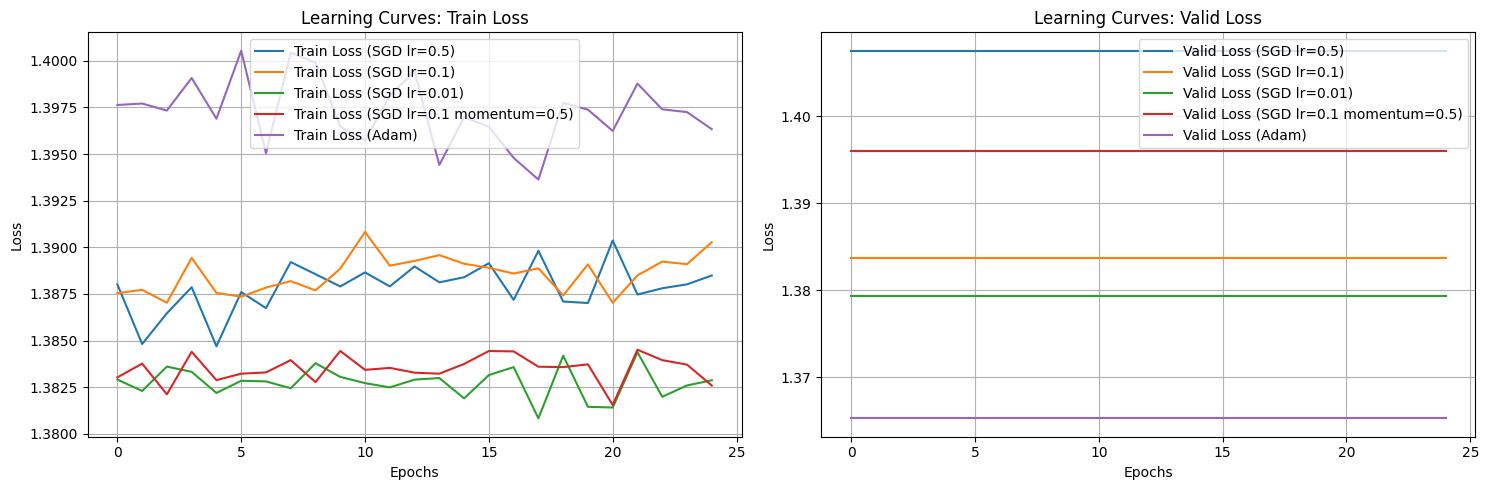

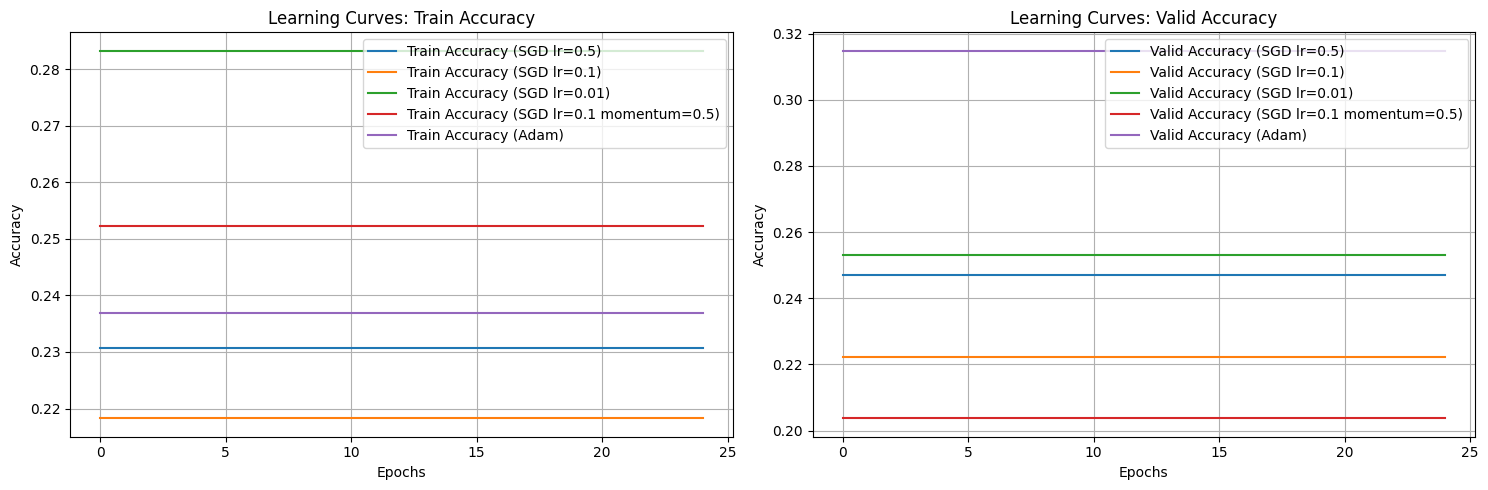

In [18]:
import torch.optim as optim
import matplotlib.pyplot as plt

def train_model(model, optimizer, criterion, num_epochs, train_loader, valid_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        valid_loss, valid_accuracy = evaluate_model(model, valid_loader, device)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

    return train_losses, train_accuracies, valid_losses, valid_accuracies

# Define the optimization strategies
optimizers = [
    optim.SGD(model.parameters(), lr=0.5),
    optim.SGD(model.parameters(), lr=0.1),
    optim.SGD(model.parameters(), lr=0.01),
    optim.SGD(model.parameters(), lr=0.1, momentum=0.5),
    optim.Adam(model.parameters())
]

# Define the names of the optimization strategies for the legend
optimizer_names = [
    'SGD lr=0.5',
    'SGD lr=0.1',
    'SGD lr=0.01',
    'SGD lr=0.1 momentum=0.5',
    'Adam'
]

# Initalise the lists to store the results
train_losses_list = []
valid_losses_list = []
train_accuracies_list = []
valid_accuracies_list = []

# Train the model for each optimization strategy
for optimizer in optimizers:
    model = SimpleCNN()  
    train_losses, train_accuracies, valid_losses, valid_accuracies = train_model(model, optimizer, criterion, num_epochs=25, train_loader=train_loader, valid_loader=valid_loader)
    train_losses_list.append(train_losses)
    valid_losses_list.append(valid_losses)
    train_accuracies_list.append(train_accuracies)
    valid_accuracies_list.append(valid_accuracies)

# Trace the learning curves of the loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
for i in range(len(optimizers)):
    plt.plot(train_losses_list[i], label=f'Train Loss ({optimizer_names[i]})', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves: Train Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i in range(len(optimizers)):
    plt.plot(valid_losses_list[i], label=f'Valid Loss ({optimizer_names[i]})', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves: Valid Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Trace the curves of the accuracy  
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
for i in range(len(optimizers)):
    plt.plot(train_accuracies_list[i], label=f'Train Accuracy ({optimizer_names[i]})', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curves: Train Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i in range(len(optimizers)):
    plt.plot(valid_accuracies_list[i], label=f'Valid Accuracy ({optimizer_names[i]})', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curves: Valid Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Fine tuning - resnet50

We will now implement a fine-tuning strategy to build the classifier.

The pytorch model zoo is available [here](https://pytorch.org/serve/model_zoo.html).

We propose to use the pre-trained architecture [resnet50](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html)

We are now going to :
> - Load the pre-trained architecture,   
>
> - Display the names of all the network layers. Identify the last layer and give its input and output dimensions.
>
> - Replace the last layer with a fully-connected layer of dimension 4 at the output, corresponding to the 4 classes in our problem.
>
> - Freeze all the layers in the network,    
>
> - Train this last layer (the rest being frozen) and evaluate the performance obtained on the validation sample.

 
 

### With ADAM

In [19]:
# Load the pre-trained ResNet-50 architecture
resnet50 = models.resnet50(pretrained=True)

# Print the names of all the layers in the network
print(resnet50)

# Size of the input and output of the last layer
last_layer_name, last_layer = list(resnet50.named_children())[-1]
print(f"Name of the last layer : {last_layer_name}")
print(f"Size of the input of last layer : {last_layer.in_features}")
print(f"Size of the output of last layer : {last_layer.out_features}")

# Replace the last layer with a fully-connected layer of dimension 4 as output
num_classes = 4
resnet50.fc = nn.Linear(last_layer.in_features, num_classes)

# Freeze all the layers of the network
for param in resnet50.parameters():
    param.requires_grad = False

# Unfreeze the last layer
for param in resnet50.fc.parameters():
    param.requires_grad = True

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.fc.parameters(), lr=0.001)

# Train the last layer of the network
num_epochs = 10
for epoch in range(num_epochs):
    resnet50.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

# Evaluate the performance on the validation set
resnet50.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

validation_accuracy = correct / total
print(f"Accuracy on validation set: {validation_accuracy:.4f}")

c:\Users\jonat\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jonat\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### With SGD

In [20]:
model = models.resnet50(pretrained=True)

# Replace the last layer with a fully-connected layer of dimension 4 as output
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)

# Freeze all layers except the last one
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last layer for training
for param in model.fc.parameters():
    param.requires_grad = True

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad() 
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()  
        optimizer.step()  
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Évaluer le modèle
# Evaluate it
model.eval()  
correct = 0
total = 0
with torch.no_grad():
    for images, labels in valid_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on validation set: {accuracy:.4f}")

Epoch [1/10], Loss: 1.3284
Epoch [2/10], Loss: 0.9049
Epoch [3/10], Loss: 0.7456
Epoch [4/10], Loss: 0.6704
Epoch [5/10], Loss: 0.5769
Epoch [6/10], Loss: 0.5712
Epoch [7/10], Loss: 0.5729
Epoch [8/10], Loss: 0.4949
Epoch [9/10], Loss: 0.4965
Epoch [10/10], Loss: 0.5064
Accuracy on validation set: 0.7469


# Data Augmentation



To improve the generalisation capabilities of a predictor, reasonable transformations of the training sample data can be performed: in effect, new training data is synthesised. In the case of images, for example, the training base can be increased by creating new images through rotation, translation, etc.
> That's what we're going to do here:

In [21]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_dir = "data_animals"

# Load the training dataset with transformations
train_dataset_augmented = datasets.ImageFolder(root=data_dir, transform=train_transform)

# Create a DataLoader for the augmented training dataset
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)

In [22]:
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0
    for images, labels in train_loader_augmented:
        optimizer.zero_grad()  
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()  
        optimizer.step()  
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader_augmented.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Evaluate it
model.eval() 
correct = 0
total = 0
with torch.no_grad():
    for images, labels in valid_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on validation set: {accuracy:.4f}")

Epoch [1/10], Loss: 0.7502
Epoch [2/10], Loss: 0.5631
Epoch [3/10], Loss: 0.5230
Epoch [4/10], Loss: 0.4221
Epoch [5/10], Loss: 0.4001
Epoch [6/10], Loss: 0.3771
Epoch [7/10], Loss: 0.3639
Epoch [8/10], Loss: 0.3720
Epoch [9/10], Loss: 0.3777
Epoch [10/10], Loss: 0.3219
Accuracy on validation set: 0.7840


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

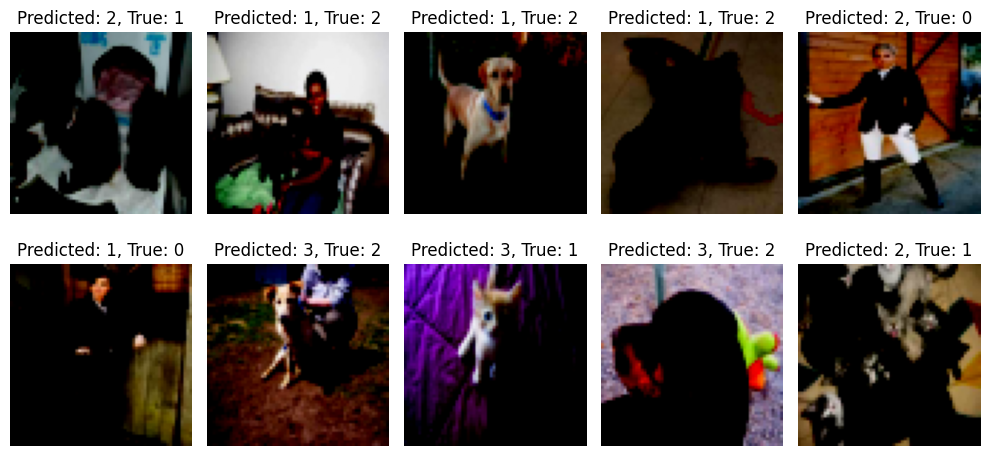

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model on the validation set
model.eval()
misclassified_images = []
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        misclassified_images.extend(images[predicted != labels])  # Collect misclassified images
        predicted_labels.extend(predicted[predicted != labels].cpu().numpy())  # Collect predicted labels for misclassified images
        true_labels.extend(labels[predicted != labels].cpu().numpy())  # Collect true labels for misclassified images

# Print some misclassified images
num_images_to_display = min(10, len(misclassified_images))
plt.figure(figsize=(10, 5))
for i in range(num_images_to_display):
    plt.subplot(2, 5, i+1)
    plt.imshow(misclassified_images[i].permute(1, 2, 0).cpu().numpy())  # Convert the image tensor to numpy
    plt.title(f"Predicted: {predicted_labels[i]}, True: {true_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

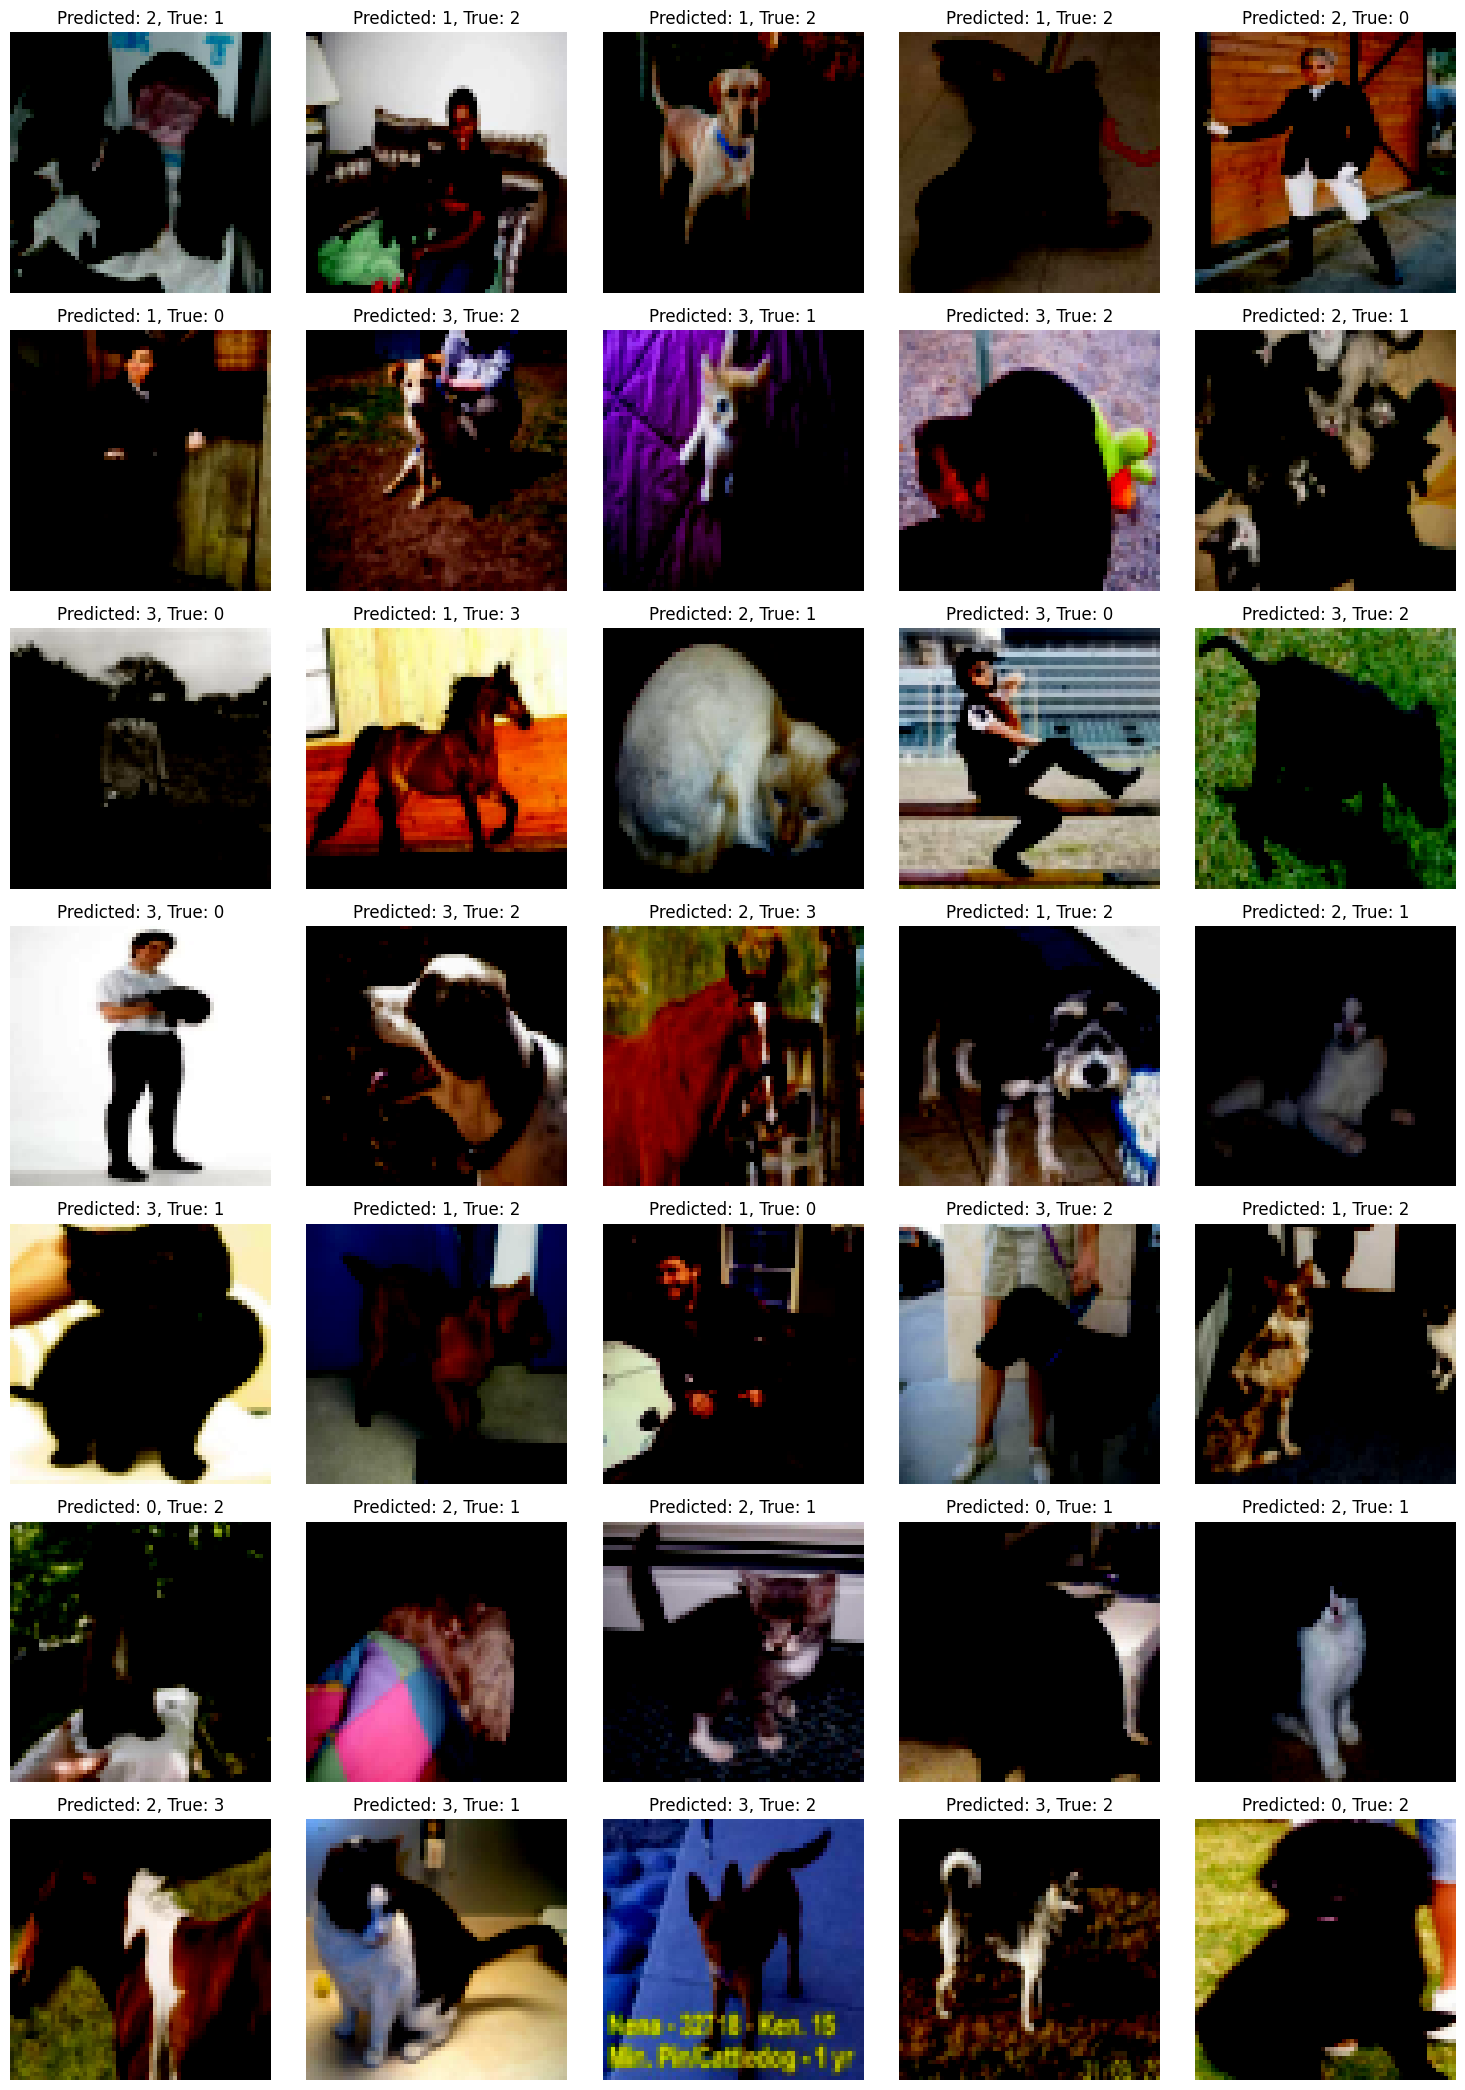

In [24]:
import math

# Calculate the number of rows and columns needed to display all misclassified images
num_images = len(misclassified_images)
num_cols = 5
num_rows = math.ceil(num_images / num_cols)

# To print all the misclassified images
plt.figure(figsize=(15, 3*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(misclassified_images[i].permute(1, 2, 0).cpu().numpy())  # Convertir de Tensor à NumPy array et réorganiser les canaux
    plt.title(f"Predicted: {predicted_labels[i]}, True: {true_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()